# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
!pip install lightning wandb
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.5 MB/s eta 0:00:0000:01
--2025-01-26 08:44:18--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2025-01-26 08:44:18--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octe

In [2]:
# !wandb login
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: theepob (theepob-chulalongkorn-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [4]:
!wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

--2025-01-26 08:44:35--  https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324399 (317K) [text/plain]
Saving to: ‘mp_name_th_en.csv’

mp_name_th_en.csv   100%[===================>] 316.80K  --.-KB/s    in 0.02s   

2025-01-26 08:44:36 (14.8 MB/s) - ‘mp_name_th_en.csv’ saved [324399/324399]



In [5]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [6]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [7]:
#Preprocessing
input_chars = sorted(list(set(''.join(name_th))))
input_chars.insert(0, "<PAD>")

print(input_chars)

output_chars = sorted(list(set(''.join(name_en))))
output_chars.insert(0, "<PAD>")
output_chars.insert(1, "</s>")

data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max input length

['<PAD>', ' ', 'ก', 'ข', 'ค', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', '็', '่', '้', '๊', '๋', '์']
There are 10887 lines and 66 unique characters in your input data.


In [8]:
def encode(sentence,map_stoi):
    result=[]
    for c in sentence:
        result.append(map_stoi[c])
    return result

def decode(encoded_lst,map_itos):
    result=""
    for i in encoded_lst:
        result+=map_itos[i]
    return result

In [9]:
map_stoi_th = { c:i for i, c in enumerate(input_chars) }
map_itos_th = { i:c for i, c in enumerate(input_chars)}
map_stoi_en = { c:i for i, c in enumerate(output_chars) }
map_itos_en = { i:c for i, c in enumerate(output_chars)}

In [10]:
print(encode(name_th[0],map_stoi_th))
print(decode(encode(name_th[0],map_stoi_th),map_itos_th))

[58, 2, 34, 39, 49, 40, 64]
ไกรสีห์


In [11]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [12]:
from torch.utils.data import Dataset, DataLoader
from torch.types import Tensor

In [13]:
X = []
for name in name_th:
    X.append(torch.tensor(encode(name,map_stoi_th)))
Y = []
for name in name_en:
    Y.append(torch.tensor(encode(name,map_stoi_en)))

X = nn.utils.rnn.pad_sequence(X, batch_first=True)
Y = nn.utils.rnn.pad_sequence(Y, batch_first=True)
X.shape, Y.shape

(torch.Size([10887, 20]), torch.Size([10887, 19]))

In [14]:
X[0],Y[0]

(tensor([58,  2, 34, 39, 49, 40, 64,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0]),
 tensor([12, 18,  3, 11, 19, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0]))

In [15]:
class NameDataset(Dataset):
  def __init__(self, X, y):
    self.x = X.long()
    self.label = y.long()

  def __getitem__(self, idx):
    return (self.x[idx],self.label[idx])

  def __len__(self):
    return len(self.x)

In [16]:
class NameDataModule(L.LightningDataModule):

  def __init__(self, train_data, y, batch_size, num_workers=0):
      super().__init__()
      self.train_data = train_data
      self.y = y
      self.batch_size = batch_size
      self.num_workers = num_workers


  # def setup(self, stage: str):
  #   pass

  def collate_fn(self, batch):
    one_hot_x = torch.stack([F.one_hot(b[0], num_classes=len(map_stoi_th)) for b in batch])
    y =  torch.stack([b[1] for b in batch])
    return (one_hot_x.float(),y)
          

  def train_dataloader(self):
    train_dataset = NameDataset(self.train_data, self.y)
    train_loader = DataLoader(train_dataset,
                              batch_size=self.batch_size,
                              shuffle=True,
                              collate_fn=self.collate_fn,
                              num_workers=self.num_workers)
    return train_loader


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [17]:
def one_step_attention(h, s_prev, linear_1, linear_2):

    #Split into Key-Value
    key, value = torch.split(h, h.size()[2] // 2, dim=2)
    
    #do concat with s_prev.
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful
    s_prev = s_prev.unsqueeze(1).repeat((1, h.shape[1], 1))
    concat = torch.cat([key, s_prev], dim=-1)
    #Attention function###
    e = F.tanh(linear_1(concat))
    energies = F.relu(linear_2(e))
    # use layer(s) from your model to calculate attention_scores and then softmax
    attention_scores = F.softmax(energies, dim=1)
    # calculate a context vector
    a_h = torch.mul(attention_scores, value)
    context_vector = torch.sum(a_h, dim=1)
    return context_vector, attention_scores

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [18]:
class AttentionModel(L.LightningModule):
    def __init__(self, lr, criterion):

        super().__init__()
        self.n_h = 64 #hidden dimensions for encoder
        self.n_s = 64#hidden dimensions for decoder
        self.lr = lr
        self.criterion = criterion
        #encoder can be any RNN of your choice
        bidirection = True
        self.num_directions = 2 if bidirection else 1
        self.lstm = nn.LSTM(len(map_stoi_th), self.n_h, bidirectional=bidirection, batch_first=True)
        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(map_stoi_en))
        #attention
        self.linear_1 = nn.Linear(self.n_h*self.num_directions, self.n_h//2)
        self.linear_2 = nn.Linear(self.n_h//2, 1)

    def forward(self, src, return_attention=False): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        lstm_out, _ = self.lstm(src)
        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], maxlen_out, len(map_stoi_en))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(maxlen_out):

            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.linear_1, self.linear_2)
            attention_scores.append(attention_score)
            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))
            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)
            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch[0]
        target = batch[1]
        prediction,_ = self(src)
        prediction = prediction.reshape(-1, len(map_stoi_en))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch[0]
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
              print("".join(decode(pred.cpu().numpy(),map_itos_en)))
            # print("".join(map_stoi_en.lookup_tokens(pred.cpu().numpy())))
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

In [19]:
model = AttentionModel(lr=0.003, criterion = nn.CrossEntropyLoss())

In [20]:
batch_size = 64
data_module = NameDataModule(X, Y, batch_size)

In [21]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw3.1_attention")

In [22]:
trainer = L.Trainer(
    max_epochs=250,
    logger=wandb_logger
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | train
1 | lstm              | LSTM             | 67.1 K | train
2 | decoder_lstm_cell | LSTMCell         | 33.3 K | train
3 | output_layer      | Linear           | 1.6 K  | train
4 | linear_1          | Linear           | 4.1 K  | train
5 | linear_2          | Linear           | 33     | train
---------------------------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=250` reached.


# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [76]:
EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ',"ธีภพ"]
predict_data = []
for name in EXAMPLES:
    line = [c for c in name]
    predict_data.append(torch.tensor(encode(name,map_stoi_th)))

def collate_fn(batch):
    one_hot_x = torch.stack([F.one_hot(b[0], num_classes=len(map_stoi_th)) for b in batch])
    return (one_hot_x.float(),0)

predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first=True)
# print(predict_data.shape)
predict_data = NameDataset(predict_data, torch.stack([torch.tensor(0)]*len(predict_data)))
predict_loader = DataLoader(predict_data,
                            batch_size=1,
                            shuffle=False,
                            collate_fn=collate_fn,
                            num_workers=0)

In [77]:
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (lstm): LSTM(65, 64, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(64, 64)
  (output_layer): Linear(in_features=64, out_features=24, bias=True)
  (linear_1): Linear(in_features=128, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)

In [78]:
output = trainer.predict(model, predict_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

pranutthatutttttttt
somchaia<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
thanttharon<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
newin<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
suthep<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
prawit<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>
chatchahhhhhhhhhhhh
thiphop<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [79]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
prediction, attention_scores = zip(*output)
idx = -1
sample_pred = prediction[idx]
sample_pred = [p for p in sample_pred.cpu().numpy().tolist()[0] if p != 0]
sample_attention_scores = attention_scores[-1]

attn_viz = torch.stack(sample_attention_scores).squeeze().cpu().numpy()
attn_viz = attn_viz[:len(EXAMPLES[-1])+1, :len(sample_pred)+1]
output_text = [c for c in decode(sample_pred,map_itos_en)]
output_text.append("<PAD>")
xlabels = [c for c in EXAMPLES[idx]]
xlabels.append("<PAD>")
print(output_text, xlabels)

['t', 'h', 'i', 'p', 'h', 'o', 'p', '<PAD>'] ['ธ', 'ี', 'ภ', 'พ', '<PAD>']


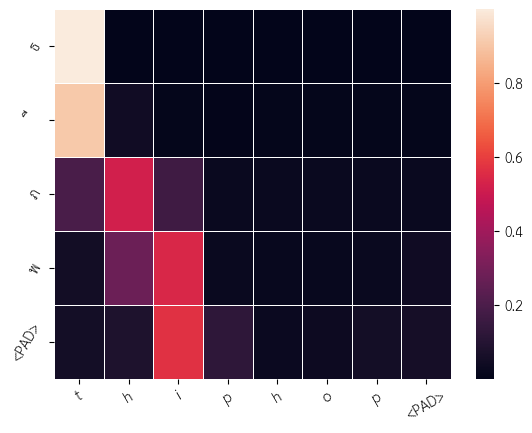

In [97]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_xticklabels(output_text,rotation=30)
ax.set_yticklabels(xlabels,rotation=60)
plt.show()